In [26]:
import matplotlib.pyplot as plt, argparse, numpy as np, math, sys, copy
from skimage.segmentation import slic, mark_boundaries, felzenszwalb
from skimage.util import img_as_float
from scipy.cluster import hierarchy
from skimage import io
from collections import defaultdict
import SPHC as sphc
import numpy as np

In [2]:
imagePath = 'images/face2.jpg'

#SLIC Parameters:
numSegments = 500  # How many superpixels to start with - input for SLIC function

#SPHC Parameters:
segmentsToMerge =[400, 500]#  [70, 80, 90] #[100, 200, 300, 400, 480] #3 # How many superpixels to merge based on color similarity
distance_limit = 30 # Limits which segments get merged based on their difference in average color

In [15]:
image = img_as_float(io.imread(imagePath))
#segments = felzenszwalb(image, scale=200, sigma=0.5, min_size=20)
segments = slic(image, slic_zero = True)

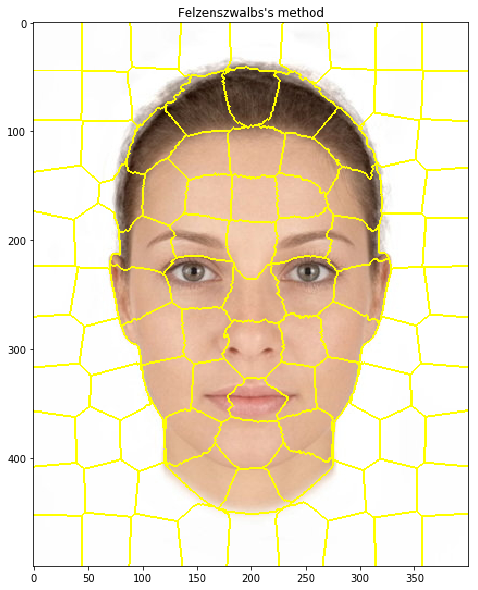

In [16]:
fig, ax = plt.subplots(1,1, figsize=(10, 10))
ax.imshow(mark_boundaries(image, segments))
ax.set_title("Felzenszwalbs's method")
plt.show()

In [35]:
#tamanho da image (400x500)
#Integer mask indicating segment labels.
avg = np.average(segments,axis=1)
print(avg)

[  3.9375   3.9375   3.9375   3.9375   3.935    3.9375   3.9375   3.9375
   3.9375   3.935    3.935    3.935    3.9375   3.9375   3.9375   3.9375
   3.9375   3.9375   3.94     3.94     3.94     3.94     3.94     3.9375
   3.9375   3.935    3.935    3.935    3.935    3.935    3.935    3.9375
   3.9375   3.9375   3.94     3.94     3.9375   3.9375   3.9375   3.9375
   3.935    4.0125   4.625    5.505    6.395   10.455   11.235   11.5125
  11.76    12.      12.1975  12.235   12.36    12.44    12.4775  12.6025
  12.675   12.72    12.7575  12.765   12.8025  12.8425  12.835   12.85
  12.87    12.8975  12.905   12.945   12.9875  13.02    13.025   13.0375
  13.07    13.115   13.1925  13.2     13.22    13.2825  13.3475  13.52
  13.5725  13.605   13.6625  13.7925  13.98    14.205   14.395   14.6
  14.785   15.09    16.4675  17.655   17.73    17.89    18.06    18.435
  18.775   19.1975  19.43    19.575   20.2075  20.5125  20.94    21.1325
  21.365   21.62    21.7125  21.79    21.8325  21.8675  21.

In [5]:
segm_size = len(segments)
segmentsToMerge =[segm_size*.20, segm_size*.25]

In [8]:
SPHCsegm_grid = sphc.getSPHCsegmentsVect(segments
                                         , image
                                         , numToMerge = segmentsToMerge
                                         , max_dist = distance_limit)

Initiating Segment Attributes...
Merging Segments...
126 segments merged - final


In [7]:
fig = plt.figure("Segments", figsize = (10,10))
ax = fig.add_subplot(1,1,1)

cp_image = image.copy()

i = 1
for segs in SPHCsegm_grid: 
    i2 = i+1
    cp_image = mark_boundaries(cp_image
                               , segs
                               , mode = 'inner'
                               , outline_color=(1/i,1/i,1/i))
    i+=1

ax.imshow(cp_image)
plt.axis("off")
plt.show()

AttributeError: 'collections.defaultdict' object has no attribute 'dtype'